In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from cmcrameri import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from sklearn.feature_selection import f_regression

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")
folder_usgs = os.path.join(folder_AGVA, 'USGS_Benchmark_data')

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# replace "True" and "False" with 1/0
all_data_gdf.replace({"False": 0, "True": 1}, inplace=True)

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 82)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200'
 'hyps_aar_220' 'hyps_aar_240' 'hyps_aar_260' 'hyps_aar_280'
 'hyps_aar_300' 'hyps_aar_320' 'hyps_aar_340' 'hyps_aar_360'
 'hyps_aar_380' 'hyps_aar_400' 'hyps_a

In [4]:
# open mass balance data for each of the 4 benchmark glaciers
df_wolv = pd.read_csv(os.path.join(folder_usgs,'Wolverine','Output_Wolverine_Glacier_Wide_solutions_calibrated.csv'))
df_gulk = pd.read_csv(os.path.join(folder_usgs,'Gulkana','Output_Gulkana_Glacier_Wide_solutions_calibrated.csv'))
df_lemc = pd.read_csv(os.path.join(folder_usgs,'LemonCreek','Output_LemonCreek_Glacier_Wide_solutions_calibrated.csv'))
df_taku = pd.read_csv(os.path.join(folder_usgs,'Taku','Output_Taku_Glacier_Wide_solutions_calibrated.csv'))

# subset the dfs to 2018-2022
df_wolv = df_wolv[ (df_wolv['Year']>2017) & (df_wolv['Year']<2023)]
df_gulk = df_gulk[ (df_gulk['Year']>2017) & (df_gulk['Year']<2023)]
df_lemc = df_lemc[ (df_lemc['Year']>2017) & (df_lemc['Year']<2023)]
df_taku = df_taku[ (df_taku['Year']>2017) & (df_taku['Year']<2023)]
                  
# grab the RGIId for each glacier (also o3 and o2 region)
all_o3s = []
all_o2s = []

rgi_dic = {}
for g in ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']:
    r = all_data_gdf[all_data_gdf['Name']==f"{g} Glacier"]['RGIId'].values[0]
    rgi_dic[g]=r

o3_dic = {}
for g in ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']:
    r = all_data_gdf[all_data_gdf['Name']==f"{g} Glacier"]['O3Region'].values[0]
    o3_dic[g]=r
    all_o3s.append(r)

o2_dic = {}
for g in ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']:
    r = all_data_gdf[all_data_gdf['Name']==f"{g} Glacier"]['O2Region'].values[0]
    o2_dic[g]=r
    all_o2s.append(r)

In [5]:
# add remotely-sensed ela, aar, date to dfs
labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    df = dfs[i]
    r = rgi_dic[labels[i]]
    
    remote_df = all_data_gdf[all_data_gdf['RGIId']==r]
    df['date_s2'] = pd.to_datetime([remote_df[f"date_{y}"].values[0] for y in range(2018,2023)])
    df['date_insitu'] = pd.to_datetime(df['Ba_Date'])
    df['days_before'] = [i.days for i in(df['date_insitu']-df['date_s2'])]
    df['ELA_s2'] = [remote_df[f"ela_{y}"].values[0] for y in range(2018,2023)]
    df['AAR_s2'] = [remote_df[f"aar_{y}"].values[0] for y in range(2018,2023)]
    df['off_glacier_s2'] = [remote_df[f"off_glacier_{y}"].values[0] for y in range(2018,2023)]
    
    rgi_info = all_data_gdf[all_data_gdf['RGIId']==r]
    zmin = rgi_info['Zmin'].values[0]
    zmax = rgi_info['Zmax'].values[0]
    zmed = rgi_info['Zmed'].values[0]
    
    df['ELA_s2_frac'] = [ min((e-zmin)/(zmax-zmin),1) for e in df['ELA_s2']]
    df['ELA_frac'] = [ min((e-zmin)/(zmax-zmin),1) for e in df['ELA']]
    
    df['ELA_s2_abovemin'] = [ min(e-zmin,zmax-zmin) for e in df['ELA_s2']]
    df['ELA_abovemin'] = [ min(e-zmin,zmax-zmin) for e in df['ELA']]
    
    df['ELA_s2_abovemed'] = [ min(e-zmed,zmax-zmed) for e in df['ELA_s2']]
    df['ELA_abovemed'] = [ min(e-zmed,zmax-zmed) for e in df['ELA']]
    
    # fix off-glacier points
    df.loc[df['off_glacier_s2'] == 1, 'ELA_s2_frac'] = 1
    df.loc[df['off_glacier_s2'] == 1, 'ELA_s2_abovemin'] = zmax-zmin
    df.loc[df['off_glacier_s2'] == 1, 'ELA_s2_abovemed'] = zmax-zmed

    # correct the off-glacier lemon creek to zmax
    df['ELA_insitu_off'] = [ min(e,zmax) for e in df['ELA']]
    temp = df['ELA_s2'].values.copy()
    for i in range(5):
        if df['off_glacier_s2'].values[i]==1:
            temp[i] = zmax
    df['ELA_s2_off'] = temp


In [6]:
df_lemc

,Year,Bw,Bs,Ba,ELA,Bw_Date,Ba_Date,Calibration,date_s2,date_insitu,...,AAR_s2,off_glacier_s2,ELA_s2_frac,ELA_frac,ELA_s2_abovemin,ELA_abovemin,ELA_s2_abovemed,ELA_abovemed,ELA_insitu_off,ELA_s2_off
65,2018,1.90,-4.58,-2.68,1778.0,2018/05/04,2018/10/25,-0.34,2018-09-16,2018-10-25,...,0.0001,1,1.000000,1.000000,818.0,818.0,371.0,371.0,1494.0,1494.0
66,2019,1.86,-5.20,-3.34,2023.0,2019/05/07,2019/10/05,-0.35,2019-09-01,2019-10-05,...,0.0000,1,1.000000,1.000000,818.0,818.0,371.0,371.0,1494.0,1494.0
67,2020,3.53,-4.63,-1.10,1180.0,2020/04/30,2020/10/16,-0.34,2020-09-13,2020-10-16,...,0.3253,0,0.518337,0.616137,424.0,504.0,-23.0,57.0,1180.0,1100.0
68,2021,3.20,-3.86,-0.66,1093.0,2021/05/04,2021/10/01,-0.34,2021-09-18,2021-10-01,...,0.4432,0,0.493888,0.509780,404.0,417.0,-43.0,-30.0,1093.0,1080.0
69,2022,3.62,-5.06,-1.44,1277.0,2022/05/10,2022/10/19,-0.34,2022-08-21,2022-10-19,...,0.6339,0,0.383863,0.734719,314.0,601.0,-133.0,154.0,1277.0,990.0


In [7]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

### calculate the region-average ela, aar variation each year

In [8]:
# add column for accumulation area of each glacier
all_data_gdf['aa_avg_product'] = all_data_gdf['aar_infill_avg_product']*all_data_gdf['Area']

for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"aa_{y}"] = all_data_gdf[f"aar_{y}"]*all_data_gdf['Area']
    
### calculate each glacier's ELA, AAR variation from ela_avg_product in each year
# note that AAR can be calculated as magnitude or percent
for y in [2018,2019,2020,2021,2022]:
    all_data_gdf[f"ela_anom_{y}"] = all_data_gdf[f"ela_{y}"]-all_data_gdf["ela_avg_product"]
    all_data_gdf[f"aar_anom_{y}_mag"] = all_data_gdf[f"aar_{y}"]-all_data_gdf["aar_avg_product"]
    all_data_gdf[f"aar_anom_{y}_per"] = all_data_gdf[f"aar_anom_{y}_mag"]/all_data_gdf["aar_avg_product"]

# add column for the total glacier area in each O2Region
temp = all_data_gdf.groupby('O2Region')['Area'].sum().rename('O2Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O2Region"))

# add column for the total glacier area in each O3Region
temp = all_data_gdf.groupby('O3Region')['Area'].sum().rename('O3Region_area')
all_data_gdf = gpd.GeoDataFrame(pd.merge(all_data_gdf, temp, on="O3Region"))

In [9]:
# start by getting the full geometry for each subregion. keep this stored in a separate gdf for later
# O3_geom = all_data_gdf[['geometry', 'O3Region']].dissolve(by='O3Region').reset_index()
# O2_geom = all_data_gdf[['geometry', 'O2Region']].dissolve(by='O2Region').reset_index()

In [64]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [10]:
#### O3 Regions
# calculating total glacier number, glacier area, mean and median size, aa, and aar for each region
o3_df = pd.DataFrame(all_data_gdf.groupby('O3Region')['Area'].count().rename('number'))
o3_df['area'] = all_data_gdf.groupby('O3Region')['Area'].sum()
o3_df['aa'] = all_data_gdf.groupby('O3Region')['aa_avg_product'].sum()
o3_df['aar'] = o3_df['aa']/o3_df['area']

# calculate dhdt for each region
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O3Region_area']) * all_data_gdf['dhdt_1520']
o3_df['dhdt_1520'] = all_data_gdf.groupby('O3Region')['temporary'].sum()
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O3Region_area']) * all_data_gdf['dhdt_1020']
o3_df['dhdt_1020'] = all_data_gdf.groupby('O3Region')['temporary'].sum()

# calculate aar each year
for y in [2018,2019,2020,2021,2022]:
    o3_df[f'aa_{y}'] = all_data_gdf.groupby('O3Region')[f'aa_{y}'].sum()
    o3_df[f'aar_{y}'] = o3_df[f'aa_{y}']/o3_df['area']
    
### calculate average elas each year, for glaciers where ela was observed
for y in [2018,2019,2020,2021,2022]:
    # for this year, subset to valid ela obs
    temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
    o3_df[f'ela_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()
    
    # do the same, but only for larger glaciers (5km2 or bigger)
    temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
    o3_df[f'ela_5km_mean_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].mean()
    o3_df[f'ela_5km_median_{y}'] = temp.groupby('O3Region')[f'ela_{y}'].median()
    
### also calculate the average ela using the average product
temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
o3_df[f'ela_mean'] = temp.groupby('O3Region')[f'ela_avg_product'].mean()
o3_df[f'ela_median'] = temp.groupby('O3Region')[f'ela_avg_product'].median()

temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
o3_df[f'ela_5km_mean'] = temp.groupby('O3Region')[f'ela_avg_product'].mean()
o3_df[f'ela_5km_median'] = temp.groupby('O3Region')[f'ela_avg_product'].median()

# get ela, aar anomaly each year
for y in [2018,2019,2020,2021,2022]:
    o3_df[f'ela_anom_{y}'] = o3_df[f'ela_median_{y}'] - o3_df[f'ela_median']
    o3_df[f'ela_5km_anom_{y}'] = o3_df[f'ela_5km_median_{y}'] - o3_df[f'ela_5km_median']
    o3_df[f'aar_anom_{y}'] = o3_df[f'aar_{y}'] - o3_df['aar']
    
# add geometry in at the end
# o3_df = gpd.GeoDataFrame(pd.merge(o3_df, O3_geom, on="O3Region"))

# remove the glaciers in O3Region=0 (these are glaciers that don't fit into any of the regions)
o3_df = o3_df.drop(0, axis=0)
o3_df.columns

Index(['number', 'area', 'aa', 'aar', 'dhdt_1520', 'dhdt_1020', 'aa_2018',
       'aar_2018', 'aa_2019', 'aar_2019', 'aa_2020', 'aar_2020', 'aa_2021',
       'aar_2021', 'aa_2022', 'aar_2022', 'ela_mean_2018', 'ela_median_2018',
       'ela_5km_mean_2018', 'ela_5km_median_2018', 'ela_mean_2019',
       'ela_median_2019', 'ela_5km_mean_2019', 'ela_5km_median_2019',
       'ela_mean_2020', 'ela_median_2020', 'ela_5km_mean_2020',
       'ela_5km_median_2020', 'ela_mean_2021', 'ela_median_2021',
       'ela_5km_mean_2021', 'ela_5km_median_2021', 'ela_mean_2022',
       'ela_median_2022', 'ela_5km_mean_2022', 'ela_5km_median_2022',
       'ela_mean', 'ela_median', 'ela_5km_mean', 'ela_5km_median',
       'ela_anom_2018', 'ela_5km_anom_2018', 'aar_anom_2018', 'ela_anom_2019',
       'ela_5km_anom_2019', 'aar_anom_2019', 'ela_anom_2020',
       'ela_5km_anom_2020', 'aar_anom_2020', 'ela_anom_2021',
       'ela_5km_anom_2021', 'aar_anom_2021', 'ela_anom_2022',
       'ela_5km_anom_2022', 'aar_

In [11]:
#### O2 Regions
# calculating total glacier number, glacier area, mean and median size, aa, and aar for each region
o2_df = pd.DataFrame(all_data_gdf.groupby('O2Region')['Area'].count().rename('number'))
o2_df['area'] = all_data_gdf.groupby('O2Region')['Area'].sum()
o2_df['aa'] = all_data_gdf.groupby('O2Region')['aa_avg_product'].sum()
o2_df['aar'] = o2_df['aa']/o2_df['area']

# calculate dhdt for each region
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O2Region_area']) * all_data_gdf['dhdt_1520']
o2_df['dhdt_1520'] = all_data_gdf.groupby('O2Region')['temporary'].sum()
all_data_gdf['temporary'] = (all_data_gdf['Area']/all_data_gdf['O2Region_area']) * all_data_gdf['dhdt_1020']
o2_df['dhdt_1020'] = all_data_gdf.groupby('O2Region')['temporary'].sum()

# calculate aar each year
for y in [2018,2019,2020,2021,2022]:
    o2_df[f'aa_{y}'] = all_data_gdf.groupby('O2Region')[f'aa_{y}'].sum()
    o2_df[f'aar_{y}'] = o2_df[f'aa_{y}']/o2_df['area']
    
### calculate average elas each year, for glaciers where ela was observed
for y in [2018,2019,2020,2021,2022]:
    # for this year, subset to valid ela obs
    temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
    o2_df[f'ela_mean_{y}'] = temp.groupby('O2Region')[f'ela_{y}'].mean()
    o2_df[f'ela_median_{y}'] = temp.groupby('O2Region')[f'ela_{y}'].median()
    
    # do the same, but only for larger glaciers (5km2 or bigger)
    temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
    o2_df[f'ela_5km_mean_{y}'] = temp.groupby('O2Region')[f'ela_{y}'].mean()
    o2_df[f'ela_5km_median_{y}'] = temp.groupby('O2Region')[f'ela_{y}'].median()
    
### also calculate the average ela using the average product
temp = all_data_gdf[all_data_gdf[f'off_glacier_{y}']==0]
o2_df[f'ela_mean'] = temp.groupby('O2Region')[f'ela_avg_product'].mean()
o2_df[f'ela_median'] = temp.groupby('O2Region')[f'ela_avg_product'].median()

temp = all_data_gdf[ (all_data_gdf[f'off_glacier_{y}']==0) & (all_data_gdf['Area']>=5) ]
o2_df[f'ela_5km_mean'] = temp.groupby('O2Region')[f'ela_avg_product'].mean()
o2_df[f'ela_5km_median'] = temp.groupby('O2Region')[f'ela_avg_product'].median()

# get ela, aar anomaly each year
for y in [2018,2019,2020,2021,2022]:
    o2_df[f'ela_anom_{y}'] = o2_df[f'ela_median_{y}'] - o2_df[f'ela_median']
    o2_df[f'ela_5km_anom_{y}'] = o2_df[f'ela_5km_median_{y}'] - o2_df[f'ela_5km_median']
    o2_df[f'aar_anom_{y}'] = o2_df[f'aar_{y}'] - o2_df['aar']
    
# add geometry in at the end
# o2_df = gpd.GeoDataFrame(pd.merge(o2_df, O2_geom, on="O2Region"))

o2_df.columns

Index(['number', 'area', 'aa', 'aar', 'dhdt_1520', 'dhdt_1020', 'aa_2018',
       'aar_2018', 'aa_2019', 'aar_2019', 'aa_2020', 'aar_2020', 'aa_2021',
       'aar_2021', 'aa_2022', 'aar_2022', 'ela_mean_2018', 'ela_median_2018',
       'ela_5km_mean_2018', 'ela_5km_median_2018', 'ela_mean_2019',
       'ela_median_2019', 'ela_5km_mean_2019', 'ela_5km_median_2019',
       'ela_mean_2020', 'ela_median_2020', 'ela_5km_mean_2020',
       'ela_5km_median_2020', 'ela_mean_2021', 'ela_median_2021',
       'ela_5km_mean_2021', 'ela_5km_median_2021', 'ela_mean_2022',
       'ela_median_2022', 'ela_5km_mean_2022', 'ela_5km_median_2022',
       'ela_mean', 'ela_median', 'ela_5km_mean', 'ela_5km_median',
       'ela_anom_2018', 'ela_5km_anom_2018', 'aar_anom_2018', 'ela_anom_2019',
       'ela_5km_anom_2019', 'aar_anom_2019', 'ela_anom_2020',
       'ela_5km_anom_2020', 'aar_anom_2020', 'ela_anom_2021',
       'ela_5km_anom_2021', 'aar_anom_2021', 'ela_anom_2022',
       'ela_5km_anom_2022', 'aar_

In [12]:
# print errors
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
dfs = [df_wolv, df_gulk, df_lemc]
df_all = pd.concat(dfs)

print("Errors for scaled ELAs")
errors_scaled = df_all['ELA_frac'] - df_all['ELA_s2_frac']
print("MeanAE:", round(np.nanmean(np.abs(errors_scaled)),4))
print("MedianAE:", round(np.nanmedian(np.abs(errors_scaled)),4))
print("Mean Bias:", round(np.nanmean(errors_scaled),4))
print("Median Bias:", round(np.nanmedian(errors_scaled),4))
print()

print("Errors for absolute ELAs")
errors_abs = df_all['ELA_insitu_off'] - df_all['ELA_s2_off']
print("MeanAE:", round(np.nanmean(np.abs(errors_abs)),4))
print("MedianAE:", round(np.nanmedian(np.abs(errors_abs)),4))
print("Mean Bias:", round(np.nanmean(errors_abs),4))
print("Median Bias:", round(np.nanmedian(errors_abs),4))
print()

print("Remove two outliers")
errors_scaled = df_all['ELA_frac'] - df_all['ELA_s2_frac']
errors_abs = df_all['ELA_insitu_off'] - df_all['ELA_s2_off']

print("MeanAE:", round( np.nanmean( np.abs(errors_scaled)[np.abs(errors_abs)<130] ), 4))
print("Bias:", round(np.nanmean(errors_scaled[np.abs(errors_abs)<130]),4))

print("MeanAE:", round(np.nanmean(np.abs(errors_abs)[np.abs(errors_abs)<130]),4))
print("Bias:", round(np.nanmean(errors_abs[np.abs(errors_abs)<130]),4))

Errors for scaled ELAs
MeanAE: 0.081
MedianAE: 0.0345
Mean Bias: 0.0144
Median Bias: 0.0159

Errors for absolute ELAs
MeanAE: 88.0667
MedianAE: 44.0
Mean Bias: 3.6667
Median Bias: 13.0

Remove two outliers
MeanAE: 0.0387
Bias: 0.0174
MeanAE: 44.1538
Bias: 17.5385


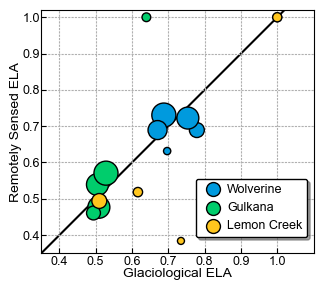

In [13]:
# make plots showing the in-situ ela vs remote ela
fig,axs = plt.subplots(figsize=(3.5,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]

labels = ['Wolverine', 'Gulkana', 'Lemon Creek']
colors = ['#009ADE', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc]

# plot data
for i in range(len(labels)):
    df = dfs[i]
    axs.scatter( df['ELA_frac'], df['ELA_s2_frac'], zorder=2,
                label=labels[i], 
                color=colors[i],
                edgecolor='black',
                s=1/df['days_before']*1500)
    
# plot 1-1 line
axs.plot([-1.5,1.5],[-1.5,1.5], c='Black', linestyle='solid', zorder=1)

axs.set_xlabel("Glaciological ELA", labelpad=0)
axs.set_ylabel("Remotely Sensed ELA", labelpad=0)

axs.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
axs.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
# axs.axis["left"].major_ticklabels.set_ha("left")

axs.set_xlim(0.35,1.1)
axs.set_ylim(0.35,1.02)

axs.set_aspect('equal')
axs.grid(zorder=1, linestyle=(0,(2,1)))

l = axs.legend(scatterpoints=1, #scatteryoffsets=[0],
               framealpha=1, edgecolor='black', shadow=True,
               labelspacing=0.5, handletextpad=0.1, fontsize=9,
               loc="lower right", bbox_to_anchor=(1,0.04))
for i in l.legend_handles: i._sizes = [100]
for t in l.get_texts(): t.set_va('baseline')

plt.tight_layout()

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'benchmark_scaled_notaku.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

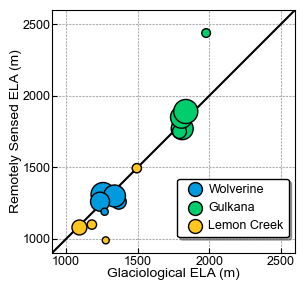

In [14]:
# make plots showing the in-situ ela vs remote ela
fig,axs = plt.subplots(figsize=(3.25,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]

labels = ['Wolverine', 'Gulkana', 'Lemon Creek']
colors = ['#009ADE', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc]

# plot data
for i in range(len(labels)):
    df = dfs[i]
    axs.scatter( df['ELA_insitu_off'], df['ELA_s2_off'], zorder=3,
                label=labels[i], 
                color=colors[i],
                edgecolor='black',
                s=1/df['days_before']*1500)
    
# plot 1-1 line
axs.plot([0,2600],[0,2600], c='Black', linestyle='solid', zorder=2)

axs.set_xlabel("Glaciological ELA (m)", labelpad=0)
axs.set_ylabel("Remotely Sensed ELA (m)", labelpad=0)

axs.set_xticks([1000, 1500, 2000, 2500])
axs.set_yticks([1000, 1500, 2000, 2500])
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
# axs.axis["left"].major_ticklabels.set_ha("left")

axs.set_xlim(900, 2599)
axs.set_ylim(900, 2599)

axs.set_aspect('equal')
axs.grid(zorder=1, linestyle=(0,(2,1)))

l = axs.legend(scatterpoints=1, #scatteryoffsets=[0],
               framealpha=1, edgecolor='black', shadow=True,
               labelspacing=0.5, handletextpad=0.1, fontsize=9,
               loc="lower right", bbox_to_anchor=(1,0.04))
for i in l.legend_handles: i._sizes = [100]
for t in l.get_texts(): t.set_va('baseline')

plt.tight_layout()

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'benchmark_abs_notaku.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

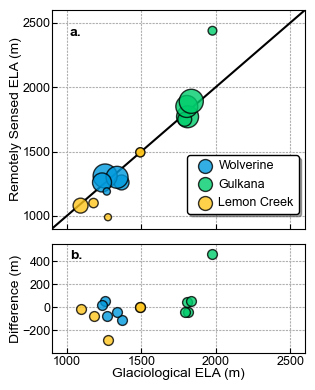

In [92]:
# make plots showing the in-situ ela vs remote ela
fig,ax_all = plt.subplots(2,1, figsize=(3.25,4),
                          sharex=True, height_ratios=[2,1])
axs = ax_all[0]
axb = ax_all[1]

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]

labels = ['Wolverine', 'Gulkana', 'Lemon Creek']
colors = ['#009ADE', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc]

# plot data
for i in range(len(labels)):
    df = dfs[i]
    axs.scatter( df['ELA_insitu_off'], df['ELA_s2_off'], zorder=3, alpha=0.8,
                label=labels[i], 
                color=colors[i],
                edgecolor='black',
                s=1/df['days_before']*1500)
    
    # magnitude of difference on top plot
    axb.scatter(df['ELA_insitu_off'], df['ELA_s2_off']-df['ELA_insitu_off'],
                zorder=3, alpha=0.8,
                label=labels[i], 
                color=colors[i],
                edgecolor='black',
                s=50)
    
# plot 1-1 line
axs.plot([0,2600],[0,2600], c='Black', linestyle='solid', zorder=2)

ax_all[1].set_xlabel("Glaciological ELA (m)", labelpad=0)
axs.set_ylabel("Remotely Sensed ELA (m)", labelpad=0)

axs.set_xticks([1000, 1500, 2000, 2500])
axs.set_yticks([1000, 1500, 2000, 2500])
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
# axs.axis["left"].major_ticklabels.set_ha("left")

axs.set_xlim(900, 2599)
axs.set_ylim(900, 2599)

# axs.set_aspect('equal')
axs.grid(zorder=1, linestyle=(0,(2,1)))

l = axs.legend(scatterpoints=1, #scatteryoffsets=[0],
               framealpha=1, edgecolor='black', shadow=True,
               labelspacing=0.5, handletextpad=0.1, fontsize=9,
               loc="lower right", bbox_to_anchor=(1,0.04))
for i in l.legend_handles: i._sizes = [100]
for t in l.get_texts(): t.set_va('baseline')

# format top plot
axb.set_ylim(-400,550)
axb.set_yticks([-200,0,200,400])
axb.grid(zorder=1, linestyle=(0,(2,1)))
axb.set_ylabel("Difference (m)", labelpad=0)
axb.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axb.tick_params(axis='y', direction='in', labelsize=9, pad=1)

axb.text(1020, 420,  "b.", weight='bold')
axs.text(1020, 2400, "a.", weight='bold')


# fig.subplots_adjust(hspace=0.02)
plt.tight_layout()

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'benchmark_abs_notaku_transparency.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

In [83]:
df_lemc['days_before']

65    39
66    34
67    33
68    13
69    59
Name: days_before, dtype: int64

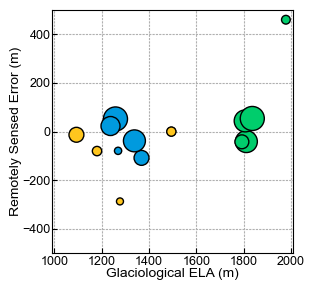

In [29]:
# make plots showing the in-situ ela vs remote ela
fig,axs = plt.subplots(figsize=(3.25,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]

labels = ['Wolverine', 'Gulkana', 'Lemon Creek']
colors = ['#009ADE', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc]

# plot data
for i in range(len(labels)):
    df = dfs[i]
    axs.scatter( df['ELA_insitu_off'], df['ELA_s2_off']-df['ELA_insitu_off'], zorder=3,
                label=labels[i], 
                color=colors[i],
                edgecolor='black',
                s=1/df['days_before']*1500)
    
# plot 1-1 line
axs.plot([0,2600],[0,2600], c='Black', linestyle='solid', zorder=2)

axs.set_xlabel("Glaciological ELA (m)", labelpad=0)
axs.set_ylabel("Remotely Sensed Error (m)", labelpad=0)

# axs.set_xticks([1000, 1500, 2000])
# axs.set_yticks([1000, 1500, 2000, 2500])
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
# axs.axis["left"].major_ticklabels.set_ha("left")

axs.set_xlim(990, 2010)
axs.set_ylim(-500, 500)

# axs.set_aspect('equal')
axs.grid(zorder=1, linestyle=(0,(2,1)))

# l = axs.legend(scatterpoints=1, #scatteryoffsets=[0],
#                framealpha=1, edgecolor='black', shadow=True,
#                labelspacing=0.5, handletextpad=0.1, fontsize=9,
#                loc="lower right", bbox_to_anchor=(1,0.04))
# for i in l.legend_handles: i._sizes = [100]
# for t in l.get_texts(): t.set_va('baseline')

plt.tight_layout()

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'benchmark_delta_notaku.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

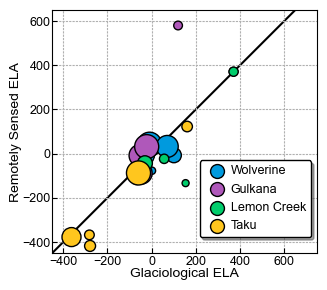

In [15]:
# make plots showing the in-situ ela vs remote ela
fig,axs = plt.subplots(figsize=(3.5,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]

# labels = ['Wolverine', 'Gulkana', 'Lemon Creek']
# colors = ['#009ADE', '#00CD6C', '#FFC61E']
# dfs = [df_wolv, df_gulk, df_lemc]

# plot data
for i in range(len(labels)):
    df = dfs[i]
    axs.scatter( df['ELA_abovemed'], df['ELA_s2_abovemed'], zorder=2,
                label=labels[i], 
                color=colors[i],
                edgecolor='black',
                s=1/df['days_before']*1500)
    
# plot 1-1 line
axs.plot([-650,650],[-650,650], c='Black', linestyle='solid', zorder=1)

axs.set_xlabel("Glaciological ELA", labelpad=0)
axs.set_ylabel("Remotely Sensed ELA", labelpad=0)

# axs.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
# axs.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
# axs.axis["left"].major_ticklabels.set_ha("left")

axs.set_xlim(-450,750)
axs.set_ylim(-450,650)

axs.set_aspect('equal')
axs.grid(zorder=1, linestyle=(0,(2,1)))

l = axs.legend(scatterpoints=1, #scatteryoffsets=[0],
               framealpha=1, edgecolor='black', shadow=True,
               labelspacing=0.5, handletextpad=0.1, fontsize=9,
               loc="lower right", bbox_to_anchor=(1,0.04))
for i in l.legend_handles: i._sizes = [100]
for t in l.get_texts(): t.set_va('baseline')

plt.tight_layout()

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'benchmark_zmed.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)

Wolverine P-values:  O2: [0.4897]   O3: [0.3155]
Gulkana P-values:  O2: [0.1292]   O3: [0.069]
Lemon Creek P-values:  O2: [0.001]   O3: [0.0013]
Taku P-values:  O2: [0.0032]   O3: [0.0002]


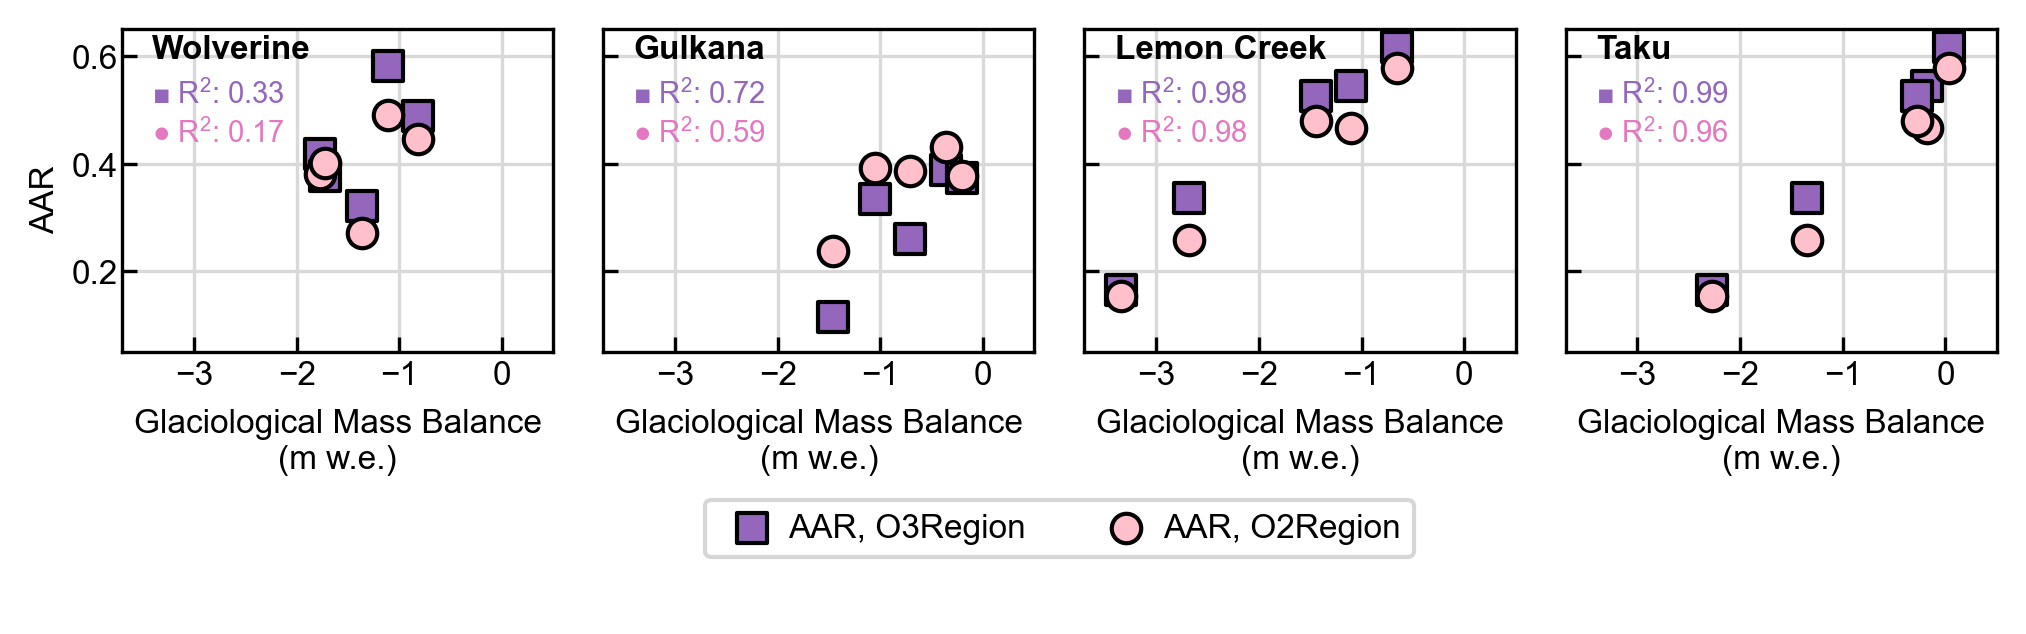

In [16]:
# I think that the glacier annual balance is the most important bit of info, so lets focus in on that
# simplify plots to show in situ Ba on x-axis, remote data on y-axis
# fig,axs = plt.subplots(2,4, figsize=(6.5,2), dpi=300, height_ratios=[2,1])

fig = plt.figure(constrained_layout=True, figsize=(6.5,2), dpi=300)
gs = fig.add_gridspec(2,4, height_ratios=[4,1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cbax = fig.add_subplot(gs[1, :])
axs = [ax1,ax2,ax3,ax4]

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    ax = axs[i]
    df = dfs[i]
    g = labels[i]
    
    # grab the O3, O2 rows that corresponds to this
    o3_n = o3_dic[g]
    o3_row = o3_df.loc[o3_n]
    o2_n = o2_dic[g]
    o2_row = o2_df.loc[o2_n]
    
    # x-axis is always gonna be Ba
    X = df['Ba'].values
    
    # then we can choose a few different y values
    y1 = df['AAR_s2'].values
    y2 = [o2_row[f"aar_{y}"] for y in range(2018,2023)] # O2 aar
    y3 = [o3_row[f"aar_{y}"] for y in range(2018,2023)] # O3 aar
    
    # plot each of the three
    ax.scatter(X, y3, zorder=2, c='tab:purple', s=50, 
               marker="s", edgecolor='black', label='AAR, O3Region')
    ax.scatter(X, y2, zorder=2, c='pink', s=50, 
               marker="o", edgecolor='black', label='AAR, O2Region')
    
    # linear regression, get r2 score
    lro3 = LinearRegression().fit(X.reshape(-1, 1), y3)
    lro2 = LinearRegression().fit(X.reshape(-1, 1), y2)
    r2o3 = lro3.score(X.reshape(-1, 1), y3)
    r2o2 = lro2.score(X.reshape(-1, 1), y2)
    
    # add text
    ax.text(0.07,0.91, g, fontsize=8, weight='bold', transform=ax.transAxes)
    ax.text(0.07,0.77, f"■ R$^2$: {round(r2o3,2)}", fontsize=7, c='tab:purple', weight='normal', transform=ax.transAxes)
    ax.text(0.07,0.65, f"● R$^2$: {round(r2o2,2)}", fontsize=7, c='tab:pink', weight='normal', transform=ax.transAxes)
    
    # calculate p values
    freg=f_regression(X.reshape(-1, 1),np.array(y2))
    p2=freg[1].round(4)
    freg=f_regression(X.reshape(-1, 1),np.array(y3))
    p3=freg[1].round(4)
    print(f"{g} P-values:  O2: {p2}   O3: {p3}")
    
#     logit_model=sm.OLS(y2,X)
#     result=logit_model.fit()
#     print(result.params)
    
    ax.set_xlabel("Glaciological Mass Balance\n(m w.e.)", size=8)
    
    ax.set_xlim(-3.7,0.5)
    ax.set_ylim(0.05,0.65)
    
    if i==0:
        ax.set_yticks([0.2,0.4,0.6])
        ax.set_yticklabels([0.2,0.4,0.6])
    else:
        ax.set_yticks([0.2,0.4,0.6])
        ax.set_yticklabels([])
    ax.set_xticks([-3,-2,-1,0])
    ax.tick_params(axis='x', direction='in', labelsize=8, pad=2)
    ax.tick_params(axis='y', direction='in', labelsize=8, pad=1)
    
    ax.grid(zorder=1, color='0.85')
    
# add legend in bottom
h, l = axs[0].get_legend_handles_labels()
cbax.legend(h, l, ncols=2, loc='upper center', bbox_to_anchor=(0.5,1.5),
           labelspacing=0.5, handletextpad=0.1, shadow=False, fontsize=8)
cbax.axis('off')

# add y-axis label
fig.text(-0.015,0.65, 'AAR', size=8, rotation=90)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'benchmark_representativeness.png')
# plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)


Wolverine P-values:  O2: [0.4897]   O3: [0.3155]
Gulkana P-values:  O2: [0.1292]   O3: [0.069]
Lemon Creek P-values:  O2: [0.001]   O3: [0.0013]


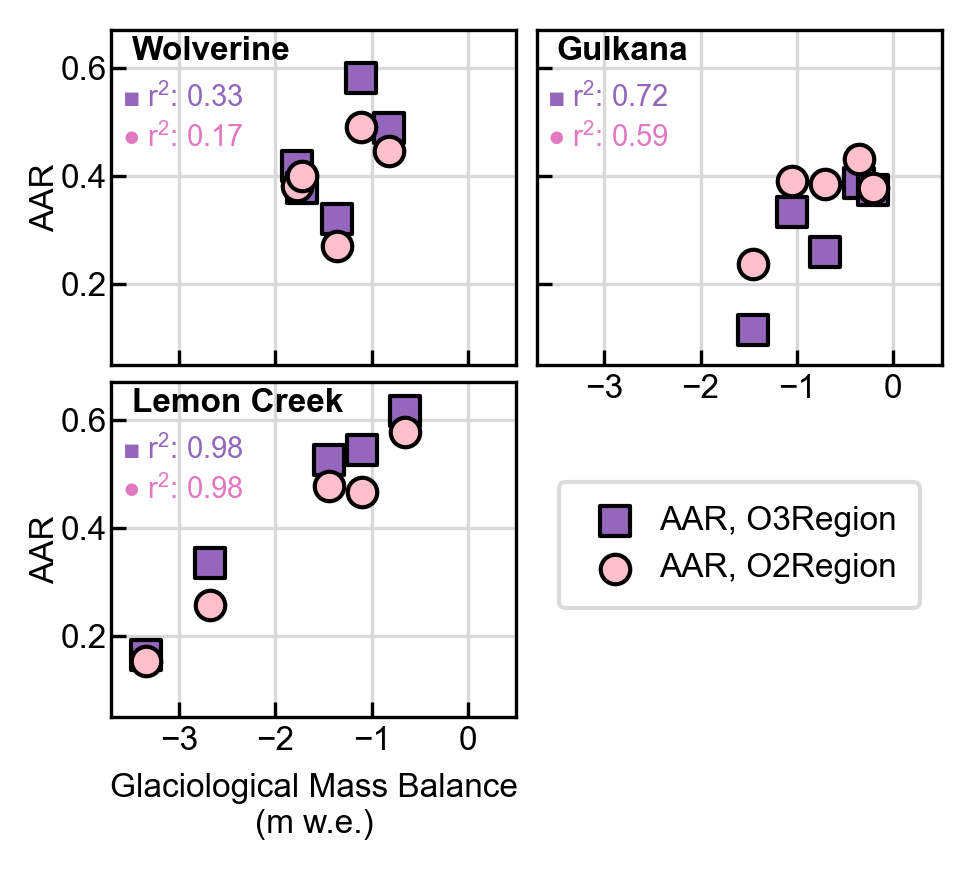

In [17]:
# I think that the glacier annual balance is the most important bit of info, so lets focus in on that
# simplify plots to show in situ Ba on x-axis, remote data on y-axis


labels = ['Wolverine', 'Gulkana', 'Lemon Creek']
dfs = [df_wolv, df_gulk, df_lemc]

fig, axs = plt.subplots(2,2, figsize=(3.35,3), dpi=300, sharex=False, sharey=False)
axs = [ axs[0,0], axs[0,1], axs[1,0], axs[1,1]]
cbax = axs[-1]
for i in [0,1,2]:
    ax = axs[i]
    df = dfs[i]
    g = labels[i]
    
    # grab the O3, O2 rows that corresponds to this
    o3_n = o3_dic[g]
    o3_row = o3_df.loc[o3_n]
    o2_n = o2_dic[g]
    o2_row = o2_df.loc[o2_n]
    
    # x-axis is always gonna be Ba
    X = df['Ba'].values
    
    # then we can choose a few different y values
    y1 = df['AAR_s2'].values
    y2 = [o2_row[f"aar_{y}"] for y in range(2018,2023)] # O2 aar
    y3 = [o3_row[f"aar_{y}"] for y in range(2018,2023)] # O3 aar
    
    # plot each of the three
    ax.scatter(X, y3, zorder=2, c='tab:purple', s=50, 
               marker="s", edgecolor='black', label='AAR, O3Region')
    ax.scatter(X, y2, zorder=2, c='pink', s=50, 
               marker="o", edgecolor='black', label='AAR, O2Region')
    
    # linear regression, get r2 score
    lro3 = LinearRegression().fit(X.reshape(-1, 1), y3)
    lro2 = LinearRegression().fit(X.reshape(-1, 1), y2)
    r2o3 = lro3.score(X.reshape(-1, 1), y3)
    r2o2 = lro2.score(X.reshape(-1, 1), y2)
    
    # add text
    ax.text(0.05,0.91, g, fontsize=8, weight='bold', transform=ax.transAxes)
    ax.text(0.025,0.77, f"■ r$^2$: {round(r2o3,2)}", fontsize=7, c='tab:purple', weight='normal', transform=ax.transAxes)
    ax.text(0.025,0.65, f"● r$^2$: {round(r2o2,2)}", fontsize=7, c='tab:pink', weight='normal', transform=ax.transAxes)
    
    # calculate p values
    freg=f_regression(X.reshape(-1, 1),np.array(y2))
    p2=freg[1].round(4)
    freg=f_regression(X.reshape(-1, 1),np.array(y3))
    p3=freg[1].round(4)
    print(f"{g} P-values:  O2: {p2}   O3: {p3}")
    
#     logit_model=sm.OLS(y2,X)
#     result=logit_model.fit()
#     print(result.params)
    
    ax.set_xlim(-3.7,0.5)
    ax.set_ylim(0.05,0.67)
    
    ax.set_yticks([0.2,0.4,0.6])
    ax.set_yticklabels([0.2,0.4,0.6])

    ax.set_xticks([-3,-2,-1,0])
    ax.tick_params(axis='x', direction='in', labelsize=8, pad=2)
    ax.tick_params(axis='y', direction='in', labelsize=8, pad=1)
    
    ax.grid(zorder=1, color='0.85')
    
# remove some tick labels
axs[1].set_yticklabels([])
axs[0].set_xticklabels([])

# add axis labels
axs[2].set_xlabel("Glaciological Mass Balance\n(m w.e.)", size=8)
# axs[2].set_xlabel("Glaciological Mass Balance\n(m w.e.)", size=8)
axs[0].set_ylabel("AAR", size=8, labelpad=0)
axs[2].set_ylabel("AAR", size=8, labelpad=0)

# add legend in bottom
h, l = axs[0].get_legend_handles_labels()
cbax.legend(h, l, ncols=1, loc='upper center', bbox_to_anchor=(0.5,0.75), edgecolor='lightgrey',
           labelspacing=0.5, handletextpad=0.3, borderpad=0.7, shadow=False, fontsize=8, fancybox=True)
cbax.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'comparisons', 'benchmark_representativeness_notaku.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)


In [18]:
# print the range of regional aar, in situ mass balance for each
labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    df = dfs[i]
    g = labels[i]
    
    # grab the O3, O2 rows that corresponds to this
    o3_n = o3_dic[g]
    o3_row = o3_df.loc[o3_n]
    o2_n = o2_dic[g]
    o2_row = o2_df.loc[o2_n]
    
    # x-axis is always gonna be Ba
    X = df['Ba'].values
    
    # then we can choose a few different y values
    y1 = df['AAR_s2'].values
    y2 = [o2_row[f"aar_{y}"] for y in range(2018,2023)] # O2 aar
    y3 = [o3_row[f"aar_{y}"] for y in range(2018,2023)] # O3 aar
    
    print(g)
    print("range ela:",min(X),max(X), max(X)-min(X))
    print("range o3: ",round(min(y3),3), round(max(y3),3), round(max(y3)-min(y3),3) )
    print("range o2: ",round(min(y2),3), round(max(y2),3), round(max(y2)-min(y2),3) )
    print()

Wolverine
range ela: -1.77 -0.82 0.9500000000000001
range o3:  0.321 0.581 0.261
range o2:  0.27 0.491 0.221

Gulkana
range ela: -1.46 -0.21 1.25
range o3:  0.115 0.387 0.272
range o2:  0.238 0.431 0.193

Lemon Creek
range ela: -3.34 -0.66 2.6799999999999997
range o3:  0.165 0.617 0.451
range o2:  0.154 0.578 0.424

Taku
range ela: -2.27 0.03 2.3
range o3:  0.165 0.617 0.451
range o2:  0.154 0.578 0.424



In [19]:
1.77-0.82

0.9500000000000001

In [20]:
2.27-0.03

2.24

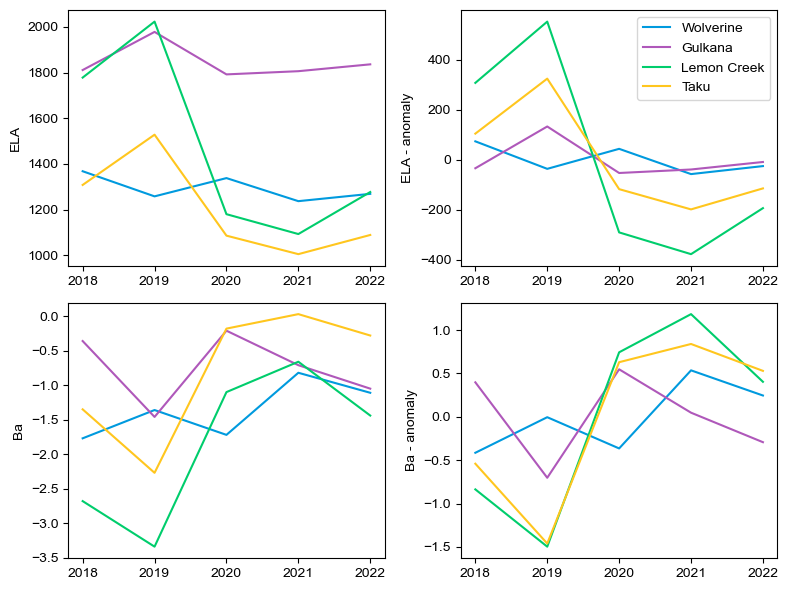

In [21]:
# inital plot showing benchmark ela, BA, remote ELA, AAR
fig,axs = plt.subplots(2,2, figsize=(8,6))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    axs[0,0].plot(dfs[i]['Year'], dfs[i]['ELA'], label=labels[i], c=colors[i])
    axs[0,1].plot(dfs[i]['Year'], dfs[i]['ELA']-np.nanmean(dfs[i]['ELA']), label=labels[i], c=colors[i])
    
    axs[1,0].plot(dfs[i]['Year'], dfs[i]['Ba'], label=labels[i], c=colors[i])
    axs[1,1].plot(dfs[i]['Year'], dfs[i]['Ba']-np.nanmean(dfs[i]['Ba']), label=labels[i], c=colors[i])
    
axs[0,0].set_ylabel('ELA')
axs[0,1].set_ylabel('ELA - anomaly')
axs[1,0].set_ylabel('Ba')
axs[1,1].set_ylabel('Ba - anomaly')
    
axs[0,1].legend()
plt.tight_layout()

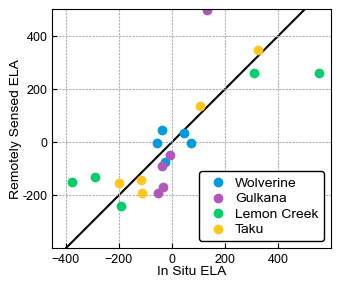

In [22]:
# make plots showing the in-situ ela vs remote ela
fig,axs = plt.subplots(figsize=(3.5,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]

# plot data
for i in [0,1,2,3]:
    df = dfs[i]
    axs.scatter( df['ELA']-np.nanmean(df['ELA']), df['ELA_s2']-np.nanmean(df['ELA_s2']),
                label=labels[i], zorder=2, color=colors[i])
    
# plot 1-1 line
axs.plot([-500,500],[-500,500], c='Black', linestyle='solid', zorder=1)

axs.set_xlabel("In Situ ELA", labelpad=0)
axs.set_ylabel("Remotely Sensed ELA", labelpad=0)

axs.set_xticks([-400,-200,0,200,400])
axs.set_yticks([-400,-200,0,200,400])
axs.set_yticklabels([-400,-200,0,200,400], ha='right')
axs.tick_params(axis='x', direction='in', labelsize=9, )
axs.tick_params(axis='y', direction='in', labelsize=9, )
# axs.axis["left"].major_ticklabels.set_ha("left")

axs.set_xlim(-450,599)
axs.set_ylim(-399,500)

axs.set_aspect('equal')
axs.grid(zorder=1, linestyle=(0,(2,1)))

axs.legend(loc="lower right", framealpha=1, edgecolor='black', labelspacing=0.2, handletextpad=0.2)

plt.tight_layout()

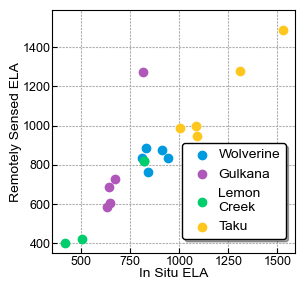

In [23]:
# make plots showing the in-situ ela vs remote ela
fig,axs = plt.subplots(figsize=(3.5,3))

labels = ['Wolverine', 'Gulkana', 'Lemon\nCreek', 'Taku']
colors = ['#009ADE', '#AF58BA', '#00CD6C', '#FFC61E']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]

# plot data
for i in [0,1,2,3]:
    df = dfs[i]
    axs.scatter( df['ELA_abovemin'], df['ELA_s2_abovemin'],
                label=labels[i], zorder=2, color=colors[i])
    
# plot 1-1 line
# axs.plot([-1.5,1.5],[-1.5,1.5], c='Black', linestyle='solid', zorder=1)

axs.set_xlabel("In Situ ELA", labelpad=0)
axs.set_ylabel("Remotely Sensed ELA", labelpad=0)

# axs.set_xticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
# axs.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0])
axs.tick_params(axis='x', direction='in', labelsize=9, pad=2)
axs.tick_params(axis='y', direction='in', labelsize=9, pad=1)
# axs.axis["left"].major_ticklabels.set_ha("left")

axs.set_xlim(350,1590)
axs.set_ylim(350,1590)

axs.set_aspect('equal')
axs.grid(zorder=1, linestyle=(0,(2,1)))

axs.legend(framealpha=1, edgecolor='black', shadow=True,
           labelspacing=0.5, handletextpad=0.2,
           loc="lower right", bbox_to_anchor=(0.99,0.03))

plt.tight_layout()

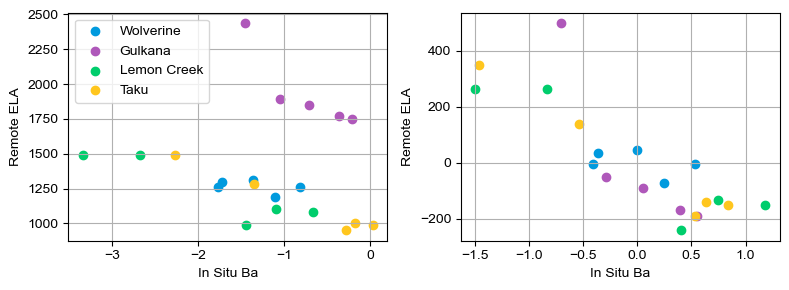

In [24]:
# make plots showing the in-situ Ba vs remote ela
fig,axs = plt.subplots(1,2, figsize=(8,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    df = dfs[i]
    
    axs[0].scatter( df['Ba'], df['ELA_s2'], label=labels[i], c=colors[i])
    axs[1].scatter( df['Ba']-np.nanmean(df['Ba']), df['ELA_s2']-np.nanmean(df['ELA_s2']), label=labels[i], c=colors[i])
    
axs[0].set_xlabel("In Situ Ba")
axs[0].set_ylabel("Remote ELA")
axs[1].set_xlabel("In Situ Ba")
axs[1].set_ylabel("Remote ELA")

axs[0].grid()
axs[1].grid()
axs[0].legend()

plt.tight_layout()

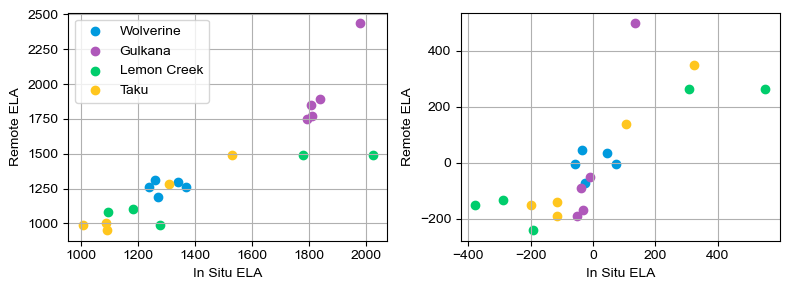

In [25]:
# make plots showing the in-situ ela vs remote ela
fig,axs = plt.subplots(1,2, figsize=(8,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    df = dfs[i]
    
    axs[0].scatter( df['ELA'], df['ELA_s2'], label=labels[i], c=colors[i])
    axs[1].scatter( df['ELA']-np.nanmean(df['ELA']), df['ELA_s2']-np.nanmean(df['ELA_s2']), label=labels[i], c=colors[i])
    
axs[0].set_xlabel("In Situ ELA")
axs[0].set_ylabel("Remote ELA")
axs[1].set_xlabel("In Situ ELA")
axs[1].set_ylabel("Remote ELA")

axs[0].grid()
axs[1].grid()
axs[0].legend()

plt.tight_layout()

### Lets see how representative each glacier is of its o2, o3 region

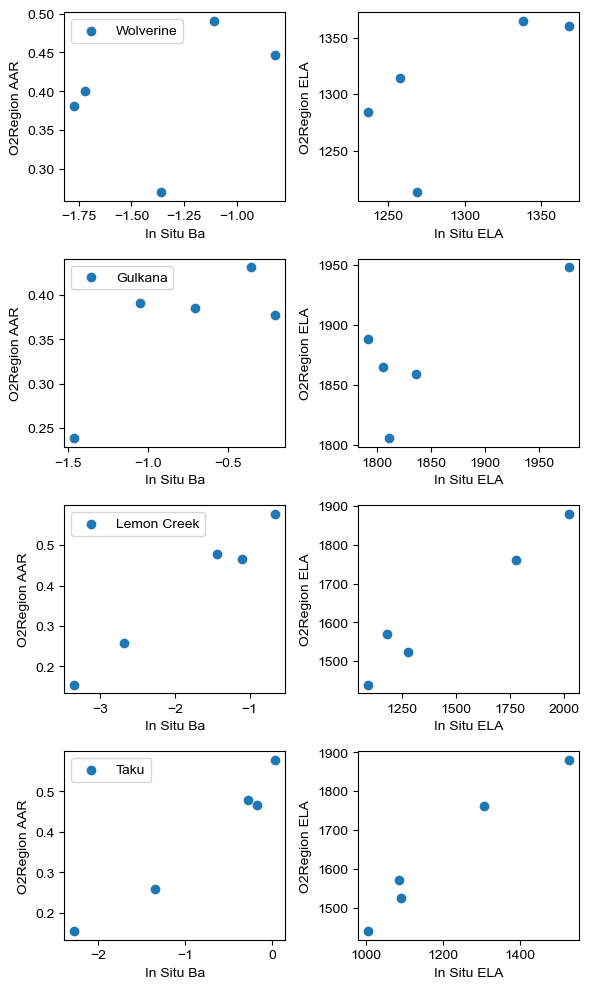

In [26]:
# O2 regions first
fig,axs = plt.subplots(4,2, figsize=(6,10))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    df = dfs[i]
    g = labels[i]
    
    # grab the O2 region row that corresponds to this
    o2_n = o2_dic[g]
    o2_row = o2_df.loc[o2_n]
    
    # plot the in situ ela vs regional AAR
    remote_data = [o2_row[f"aar_{y}"] for y in range(2018,2023)]
    axs[i,0].scatter(df['Ba'], remote_data, label=g)
    
    # plot the in situ ela vs regional ELA
    remote_data = [o2_row[f"ela_mean_{y}"] for y in range(2018,2023)]
    axs[i,1].scatter(df['ELA'], remote_data, label=g)
    
    axs[i,0].legend()
    axs[i,0].set_xlabel("In Situ Ba")
    axs[i,0].set_ylabel("O2Region AAR")
    axs[i,1].set_xlabel("In Situ ELA")
    axs[i,1].set_ylabel("O2Region ELA")
plt.tight_layout()

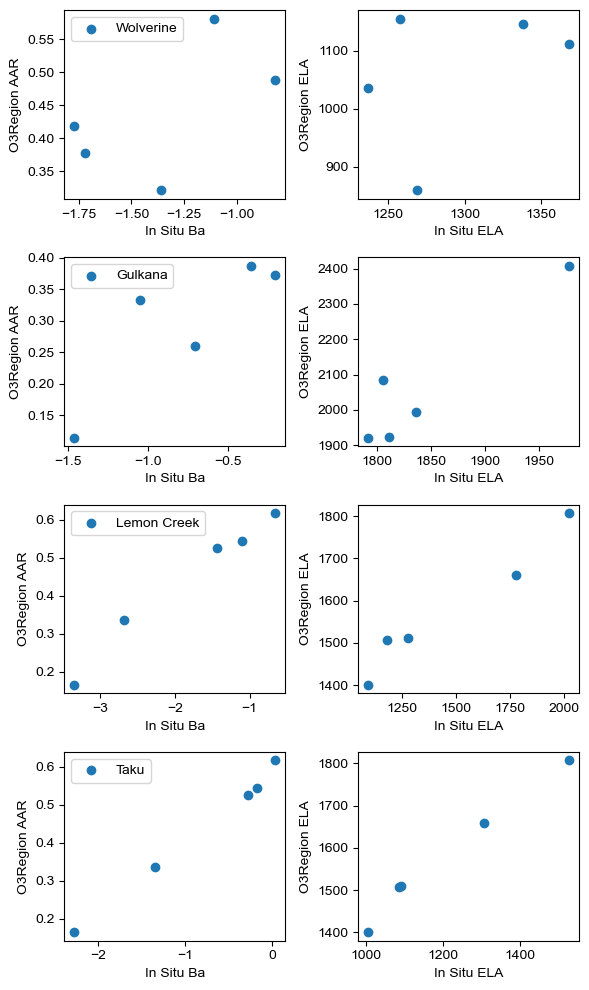

In [27]:
# O3 regions
fig,axs = plt.subplots(4,2, figsize=(6,10))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    df = dfs[i]
    g = labels[i]
    
    # grab the O3 region row that corresponds to this
    o3_n = o3_dic[g]
    o3_row = o3_df.loc[o3_n]
    
    # plot the in situ ela vs regional AAR
    remote_data = [o3_row[f"aar_{y}"] for y in range(2018,2023)]
    axs[i,0].scatter(df['Ba'], remote_data, label=g)
    
    # plot the in situ ela vs regional ELA
    remote_data = [o3_row[f"ela_mean_{y}"] for y in range(2018,2023)]
    axs[i,1].scatter(df['ELA'], remote_data, label=g)
    
    axs[i,0].legend()
    axs[i,0].set_xlabel("In Situ Ba")
    axs[i,0].set_ylabel("O3Region AAR")
    axs[i,1].set_xlabel("In Situ ELA")
    axs[i,1].set_ylabel("O3Region ELA")
plt.tight_layout()

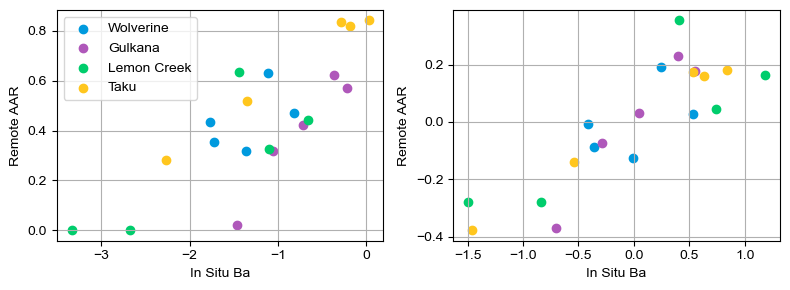

In [28]:
# make plots showing the in-situ Ba vs remote aar
fig,axs = plt.subplots(1,2, figsize=(8,3))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    df = dfs[i]
    
    axs[0].scatter( df['Ba'], df['AAR_s2'], label=labels[i], c=colors[i])
    axs[1].scatter( df['Ba']-np.nanmean(df['Ba']), df['AAR_s2']-np.nanmean(df['AAR_s2']), label=labels[i], c=colors[i])
    
axs[0].set_xlabel("In Situ Ba")
axs[0].set_ylabel("Remote AAR")
axs[1].set_xlabel("In Situ Ba")
axs[1].set_ylabel("Remote AAR")

axs[0].grid()
axs[1].grid()
axs[0].legend()

plt.tight_layout()

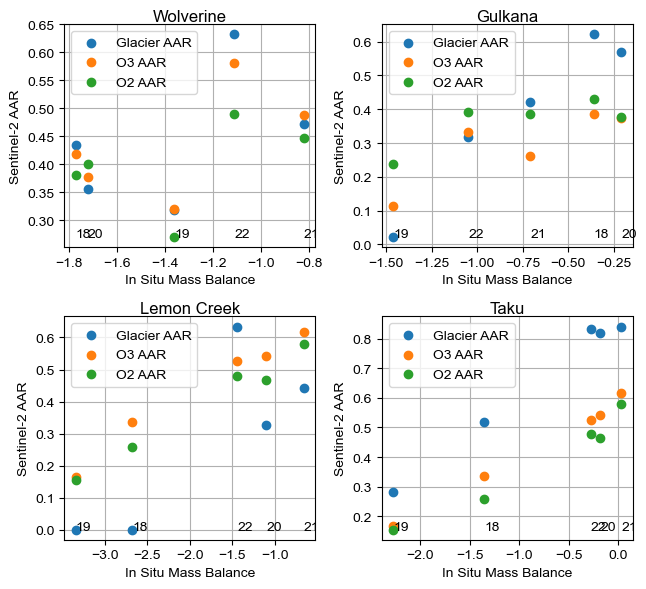

In [29]:
# I think that the glacier annual balance is the most important bit of info, so lets focus in on that
# simplify plots to show in situ Ba on x-axis, remote data on y-axis
fig,axs = plt.subplots(2,2, figsize=(6.5,6))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    ax = axs[i//2,i%2]
    df = dfs[i]
    g = labels[i]
    
    # grab the O3, O2 rows that corresponds to this
    o3_n = o3_dic[g]
    o3_row = o3_df.loc[o3_n]
    o2_n = o2_dic[g]
    o2_row = o2_df.loc[o2_n]
    
    # x-axis is always gonna be Ba
    X = df['Ba'].values
    
    # then we can choose a few different y values
    y1 = df['AAR_s2'].values
    y2 = [o2_row[f"aar_{y}"] for y in range(2018,2023)] # O2 aar
    y3 = [o3_row[f"aar_{y}"] for y in range(2018,2023)] # O3 aar
    
    # annotate the years
    for i,t in enumerate(['18','19','20','21','22']):
#         ax.text(X[i], y1[i], t)
        ax.annotate(t, (X[i], np.nanmin((min(y1),min(y2),min(y3)))))
#     ax.text(X, y1, ['18','19','20','21','22'])
    
    # plot each of the three
    ax.scatter(X, y1, zorder=2, label='Glacier AAR')
    ax.scatter(X, y3, zorder=2, label='O3 AAR')
    ax.scatter(X, y2, zorder=2, label='O2 AAR')
    
    ax.set_title(g, pad=-10)
    ax.set_xlabel("In Situ Mass Balance")
    ax.set_ylabel("Sentinel-2 AAR")
    ax.grid(zorder=1)
    ax.legend()
plt.tight_layout()

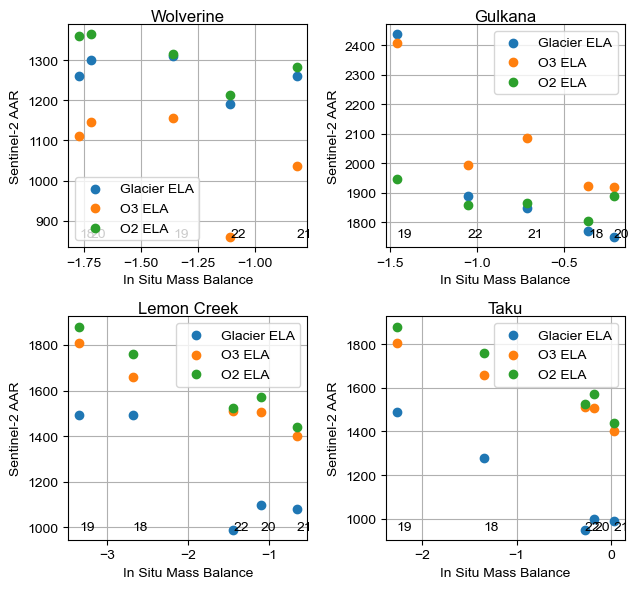

In [30]:
# I think that the glacier annual balance is the most important bit of info, so lets focus in on that
# simplify plots to show in situ Ba on x-axis, remote data on y-axis
fig,axs = plt.subplots(2,2, figsize=(6.5,6))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    ax = axs[i//2,i%2]
    df = dfs[i]
    g = labels[i]
    
    # grab the O3, O2 rows that corresponds to this
    o3_n = o3_dic[g]
    o3_row = o3_df.loc[o3_n]
    o2_n = o2_dic[g]
    o2_row = o2_df.loc[o2_n]
    
    # x-axis is always gonna be Ba
    X = df['Ba'].values
    
    # then we can choose a few different y values
    y1 = df['ELA_s2'].values
    y2 = [o2_row[f"ela_mean_{y}"] for y in range(2018,2023)] # O2 aar
    y3 = [o3_row[f"ela_mean_{y}"] for y in range(2018,2023)] # O3 aar
    
    # annotate the years
    for i,t in enumerate(['18','19','20','21','22']):
#         ax.text(X[i], y1[i], t)
        ax.annotate(t, (X[i], np.nanmin((min(y1),min(y2),min(y3)))))
#     ax.text(X, y1, ['18','19','20','21','22'])
    
    # plot each of the three
    ax.scatter(X, y1, zorder=2, label='Glacier ELA')
    ax.scatter(X, y3, zorder=2, label='O3 ELA')
    ax.scatter(X, y2, zorder=2, label='O2 ELA')
    
    ax.set_title(g, pad=-10)
    ax.set_xlabel("In Situ Mass Balance")
    ax.set_ylabel("Sentinel-2 AAR")
    ax.grid(zorder=1)
    ax.legend()
plt.tight_layout()

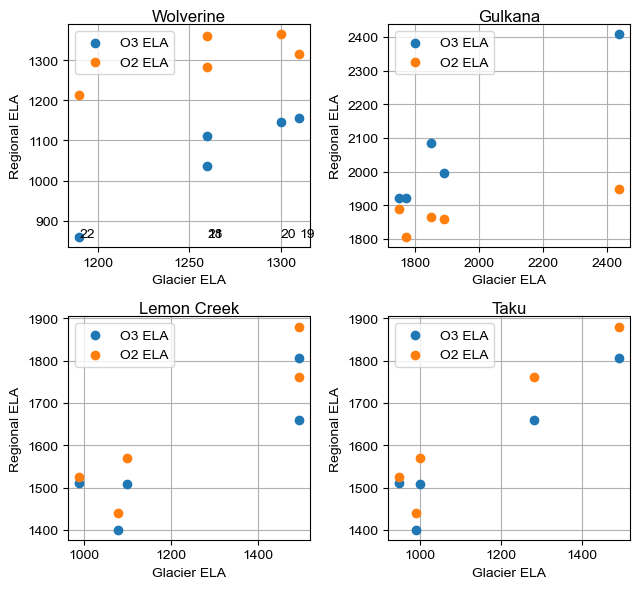

In [31]:
# I think that the glacier annual balance is the most important bit of info, so lets focus in on that
# simplify plots to show in situ Ba on x-axis, remote data on y-axis
fig,axs = plt.subplots(2,2, figsize=(6.5,6))

labels = ['Wolverine', 'Gulkana', 'Lemon Creek', 'Taku']
dfs = [df_wolv, df_gulk, df_lemc, df_taku]
for i in [0,1,2,3]:
    ax = axs[i//2,i%2]
    df = dfs[i]
    g = labels[i]
    
    # grab the O3, O2 rows that corresponds to this
    o3_n = o3_dic[g]
    o3_row = o3_df.loc[o3_n]
    o2_n = o2_dic[g]
    o2_row = o2_df.loc[o2_n]
    
    # x-axis is always gonna be Ba
    X = df['Ba'].values
    
    # then we can choose a few different y values
    X = df['ELA_s2'].values
    y2 = [o2_row[f"ela_mean_{y}"] for y in range(2018,2023)] # O2 aar
    y3 = [o3_row[f"ela_mean_{y}"] for y in range(2018,2023)] # O3 aar
    
    # annotate the years
    for i,t in enumerate(['18','19','20','21','22']):
#         ax.text(X[i], y1[i], t)
        ax.annotate(t, (X[i], np.nanmin((min(y1),min(y2),min(y3)))))
#     ax.text(X, y1, ['18','19','20','21','22'])
    
    # plot each of the three
#     ax.scatter(X, y1, zorder=2, label='Glacier AAR')
    ax.scatter(X, y3, zorder=2, label='O3 ELA')
    ax.scatter(X, y2, zorder=2, label='O2 ELA')
    
    ax.set_title(g, pad=-10)
    ax.set_xlabel("Glacier ELA")
    ax.set_ylabel("Regional ELA")
    ax.grid(zorder=1)
    ax.legend()
plt.tight_layout()

In [32]:
df_wolv

,Year,Bw,Bs,Ba,ELA,Bw_Date,Ba_Date,Calibration,date_s2,date_insitu,...,AAR_s2,off_glacier_s2,ELA_s2_frac,ELA_frac,ELA_s2_abovemin,ELA_abovemin,ELA_s2_abovemed,ELA_abovemed,ELA_insitu_off,ELA_s2_off
52,2018,1.67,-3.44,-1.77,1368,2018/05/25,2018/10/02,-0.61,2018-09-19,2018-10-02,...,0.4349,0,0.689256,0.778512,834.0,942,-7.0,101,1368,1260.0
53,2019,2.60,-3.96,-1.36,1258,2019/05/11,2019/09/19,-0.61,2019-09-14,2019-09-19,...,0.3186,0,0.730579,0.687603,884.0,832,43.0,-9,1258,1310.0
54,2020,1.50,-3.22,-1.72,1338,2020/04/15,2020/09/17,-0.61,2020-09-11,2020-09-17,...,0.3552,0,0.722314,0.753719,874.0,912,33.0,71,1338,1300.0
55,2021,1.79,-2.61,-0.82,1237,2021/04/14,2021/09/19,-0.61,2021-09-11,2021-09-19,...,0.4720,0,0.689256,0.670248,834.0,811,-7.0,-30,1237,1260.0
56,2022,2.11,-3.22,-1.11,1269,2022/05/02,2022/09/21,-0.61,2022-07-28,2022-09-21,...,0.6327,0,0.631405,0.696694,764.0,843,-77.0,2,1269,1190.0


In [33]:
df_gulk

,Year,Bw,Bs,Ba,ELA,Bw_Date,Ba_Date,Calibration,date_s2,date_insitu,...,AAR_s2,off_glacier_s2,ELA_s2_frac,ELA_frac,ELA_s2_abovemin,ELA_abovemin,ELA_s2_abovemed,ELA_abovemed,ELA_insitu_off,ELA_s2_off
52,2018,0.95,-1.31,-0.36,1811,2018/05/29,2018/09/20,-0.45,2018-09-14,2018-09-20,...,0.6218,0,0.476489,0.508621,608.0,649,-88.0,-47,1811,1770.0
53,2019,0.87,-2.33,-1.46,1978,2019/05/12,2019/09/15,-0.45,2019-08-08,2019-09-15,...,0.0219,1,1.000000,0.639498,1276.0,816,580.0,120,1978,2438.0
54,2020,1.50,-1.71,-0.21,1792,2020/05/01,2020/08/29,-0.45,2020-08-14,2020-08-29,...,0.5694,0,0.460815,0.493730,588.0,630,-108.0,-66,1792,1750.0
55,2021,0.76,-1.47,-0.71,1806,2021/05/30,2021/08/08,-0.45,2021-08-02,2021-08-08,...,0.4224,0,0.539185,0.504702,688.0,644,-8.0,-52,1806,1850.0
56,2022,0.62,-1.67,-1.05,1836,2022/05/17,2022/09/01,-0.45,2022-08-27,2022-09-01,...,0.3188,0,0.570533,0.528213,728.0,674,32.0,-22,1836,1890.0


In [34]:
df_lemc

,Year,Bw,Bs,Ba,ELA,Bw_Date,Ba_Date,Calibration,date_s2,date_insitu,...,AAR_s2,off_glacier_s2,ELA_s2_frac,ELA_frac,ELA_s2_abovemin,ELA_abovemin,ELA_s2_abovemed,ELA_abovemed,ELA_insitu_off,ELA_s2_off
65,2018,1.90,-4.58,-2.68,1778.0,2018/05/04,2018/10/25,-0.34,2018-09-16,2018-10-25,...,0.0001,1,1.000000,1.000000,818.0,818.0,371.0,371.0,1494.0,1494.0
66,2019,1.86,-5.20,-3.34,2023.0,2019/05/07,2019/10/05,-0.35,2019-09-01,2019-10-05,...,0.0000,1,1.000000,1.000000,818.0,818.0,371.0,371.0,1494.0,1494.0
67,2020,3.53,-4.63,-1.10,1180.0,2020/04/30,2020/10/16,-0.34,2020-09-13,2020-10-16,...,0.3253,0,0.518337,0.616137,424.0,504.0,-23.0,57.0,1180.0,1100.0
68,2021,3.20,-3.86,-0.66,1093.0,2021/05/04,2021/10/01,-0.34,2021-09-18,2021-10-01,...,0.4432,0,0.493888,0.509780,404.0,417.0,-43.0,-30.0,1093.0,1080.0
69,2022,3.62,-5.06,-1.44,1277.0,2022/05/10,2022/10/19,-0.34,2022-08-21,2022-10-19,...,0.6339,0,0.383863,0.734719,314.0,601.0,-133.0,154.0,1277.0,990.0


In [35]:
df_taku

,Year,Bw,Bs,Ba,ELA,Bw_Date,Ba_Date,Calibration,date_s2,date_insitu,...,AAR_s2,off_glacier_s2,ELA_s2_frac,ELA_frac,ELA_s2_abovemin,ELA_abovemin,ELA_s2_abovemed,ELA_abovemed,ELA_insitu_off,ELA_s2_off
72,2018,1.70,-3.05,-1.35,1308.0,2018/05/05,2018/10/04,-0.39,2018-09-29,2018-10-04,...,0.5193,0,0.591497,0.604436,1280.0,1308.0,-87.0,-59.0,1308.0,1280.0
73,2019,1.46,-3.73,-2.27,1528.0,2019/05/07,2019/10/05,-0.39,2019-09-09,2019-10-05,...,0.2821,0,0.688540,0.706100,1490.0,1528.0,123.0,161.0,1528.0,1490.0
74,2020,2.46,-2.64,-0.18,1086.0,2020/04/30,2020/10/16,-0.40,2020-09-15,2020-10-16,...,0.8207,0,0.462107,0.501848,1000.0,1086.0,-367.0,-281.0,1086.0,1000.0
75,2021,2.56,-2.53,0.03,1005.0,2021/05/15,2021/09/26,-0.39,2021-09-18,2021-09-26,...,0.8414,0,0.457486,0.464418,990.0,1005.0,-377.0,-362.0,1005.0,990.0
76,2022,2.67,-2.95,-0.28,1089.0,2022/05/10,2022/10/12,-0.39,2022-09-18,2022-10-12,...,0.8340,0,0.439002,0.503235,950.0,1089.0,-417.0,-278.0,1089.0,950.0
